# Wind Turbine Output Prediction using SCADA data

<center><img src="images/wind_turbines.png"/></center>

## Context
In this project we train a predictive model on Supervisory Control and Data Acquisition (SCADA) data captured from a physical wind turbine. SCADA systems are used for controlling, monitoring, and analyzing industrial devices and processes. The SCADA concept was developed to be a universal means of remote-access to a variety of local control modules, which could be from different manufacturers and allowing access through standard automation protocols.

In wind turbines SCADA Systems capture data like wind speed, wind direction, generated power etc. for predetermined intervals. This data can be used for the purposes of monitoring, predictive maintenance, generating predictions on expected power outputs and so on.

In this project we demonstrate how we can train a machine learning model using a freely available SCADA dataset, which comes from [Kaggle](https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset)

## Dataset
The samples in this dataset are distributed as a .CSV file with the following attributes:

* Date/Time --- timestamp of the observation (10 minutes intervals)
* LV ActivePower (kW) --- The amount of power generated by the turbine at that timestamp (in kWh)
* Wind Speed (m/s) --- The wind speed as measured at the hub height of the turbine
* Theoretical_Power_Curve (KWh) --- The theoretical power values that the turbine generates with that wind speed as provided by the turbine manufacturer
* Wind Direction (degrees) --- The wind direction at the hub height of the turbine (the turbine turns in this direction automaticaly)

## Notebook contents
In this notebook we ingest the data and perform exploratory data analsys. We also carry out some basic data transformation and train a predictive model using an [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html). Finally we look at some basic measures for the performance of the model and persist the trained model so it can later be deployed as a [Model API](https://docs.dominodatalab.com/en/latest/user_guide/8dbc91/deploy-models-at-rest/).

## Data Ingestion
Let's start by reading the available dataset. It is currently stored in a CSV file called ```T1.csv```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataDF = pd.read_csv("data/T1.csv")

In [3]:
dataDF.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


## Exploratory Data Analysis
We can now proceed with performing some exploratory data analysis and lightweight data manipulation. First, we notice that the column ```Date\Time``` contains a timestamp. Let's convert it to the correct data type.

In [4]:
dataDF["Date/Time"] = pd.to_datetime(dataDF["Date/Time"])

In [5]:
dataDF.dtypes

Date/Time                        datetime64[ns]
LV ActivePower (kW)                     float64
Wind Speed (m/s)                        float64
Theoretical_Power_Curve (KWh)           float64
Wind Direction (°)                      float64
dtype: object

Let's get the month & hour of the sample as separate attributes. We can also remove the timestamp as this time resolution should be sufficient for our purposes.

In [6]:
dataDF["Month"] = pd.DatetimeIndex(dataDF["Date/Time"]).month
dataDF["Hour"] = pd.DatetimeIndex(dataDF["Date/Time"]).hour
dataDF.drop(["Date/Time"], axis=1, inplace=True)

dataDF.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Hour
0,380.047791,5.311336,416.328908,259.994904,1,0
1,453.769196,5.672167,519.917511,268.641113,1,0
2,306.376587,5.216037,390.900016,272.564789,1,0
3,419.645905,5.659674,516.127569,271.258087,1,0
4,380.650696,5.577941,491.702972,265.674286,1,0


Next, we can calculate some basic descriptive statistics about the key input attributes.

In [7]:
dataDF[["LV ActivePower (kW)", "Wind Speed (m/s)", "Theoretical_Power_Curve (KWh)"]].describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh)
count,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463
std,1312.459242,4.227166,1368.018238
min,-2.471405,0.000000,0.000000
25%,50.677890,4.201395,161.328167
50%,825.838074,7.104594,1063.776283
75%,2482.507568,10.300020,2964.972462
max,3618.732910,25.206011,3600.000000


We can also look at the histograms of all variables.

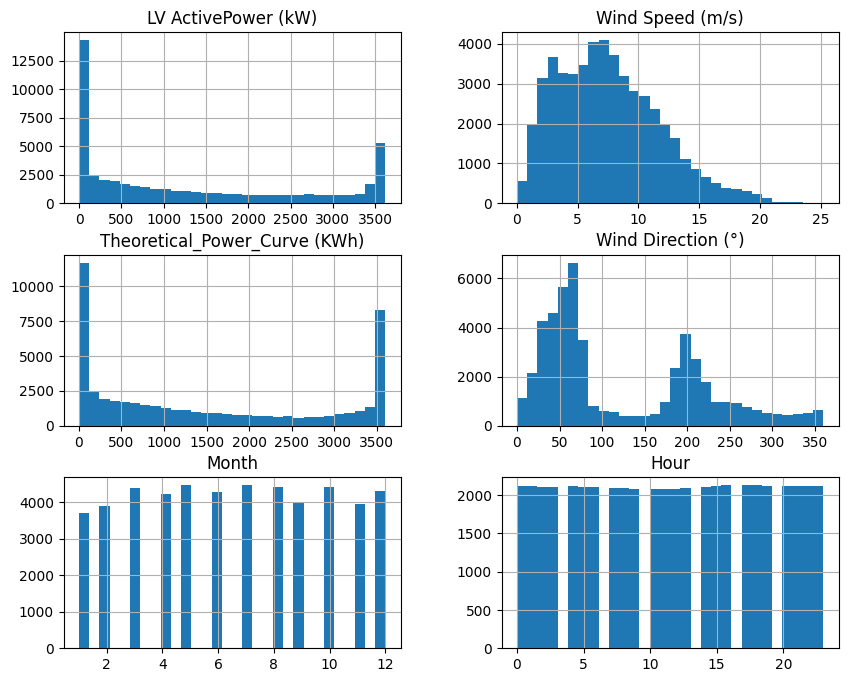

In [8]:
dataDF.hist(bins=30, figsize=(10, 8));

We observe that the Month and Hour attribues are uniformly distributed. 

We also observe that the Wind distribution has two clearly expressed peaks. This is typical for a wind turbine located in the path of bimodal wind, which oscillates seasonally between two main directions.

We see that for many observations the actual output of the turbine is 0. More interestingly, there are also many observations where the theoretical power output is also zero. We need to check if there is an overlap in these samples, which may be an indicator of the turbine simply being switched off for maintenance.

We can also generate plots to investigate how the power distribution is generated over indvidual months/hours, in case there are other anomalies we need to be aware of.

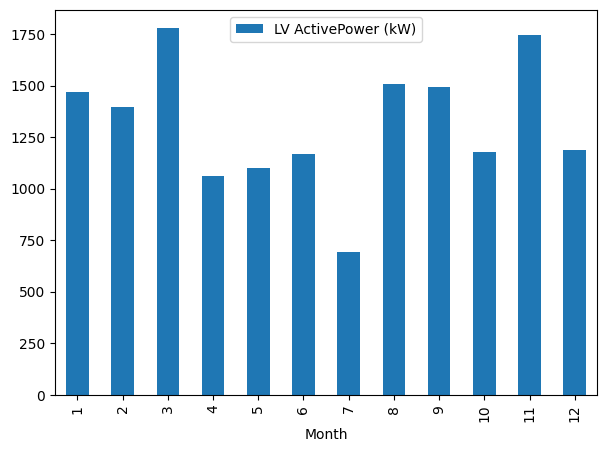

In [9]:
dataDF.groupby(["Month"], as_index=False)["LV ActivePower (kW)"].mean().plot.bar(x = "Month", figsize=(7,5));

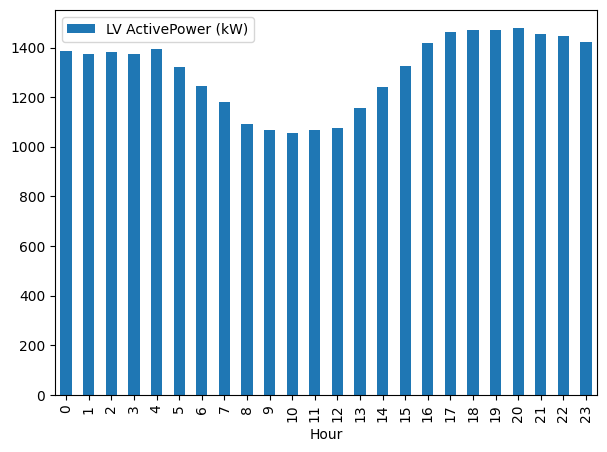

In [10]:
dataDF.groupby(["Hour"], as_index=False)["LV ActivePower (kW)"].mean().plot.bar(x = "Hour", figsize=(7,5));

Now let's plot a correlation matrix and see if we can spot any interesting relationships based on the correlation coefficients between the variables.

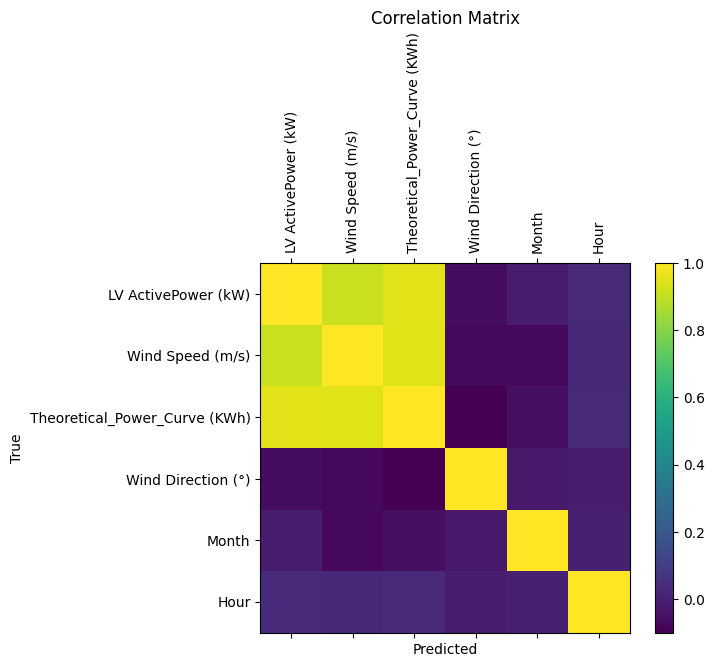

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.matshow(dataDF.corr(), interpolation="nearest")
plt.title("Correlation Matrix")
fig.colorbar(cax)

labels = dataDF.columns.values

# Fix for https://github.com/matplotlib/matplotlib/issues/18848
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.tick_params(axis='x', labelrotation = 90)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As expected, there is a very strong postive correlation between wind speed and power generation. The surprising finding here is the very strong negative correlation with Wind Direction, but this is likely due to the unit of this variable. Nevertheless, let's investigate this a bit more.

First, we'll create a new attribute ```Norm ActivePower```, by normalising the ```LV ActivePower (kW)``` data. This is purely for the purposes of plotting and making the graph easier to interpret.

In [12]:
min_power, max_power = dataDF["LV ActivePower (kW)"].min(), dataDF["LV ActivePower (kW)"].max()
normSeries = (dataDF["LV ActivePower (kW)"] - min_power) / (max_power - min_power)

dataDF.loc[normSeries.index, "Norm ActivePower"] = normSeries 

In [13]:
dataDF.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Hour,Norm ActivePower
0,380.047791,5.311336,416.328908,259.994904,1,0,0.105633
1,453.769196,5.672167,519.917511,268.641113,1,0,0.125991
2,306.376587,5.216037,390.900016,272.564789,1,0,0.085289
3,419.645905,5.659674,516.127569,271.258087,1,0,0.116568
4,380.650696,5.577941,491.702972,265.674286,1,0,0.105800


Now let's plot a polar plot showing the angle, wind speed, and power output and see if we can spot any patterns.

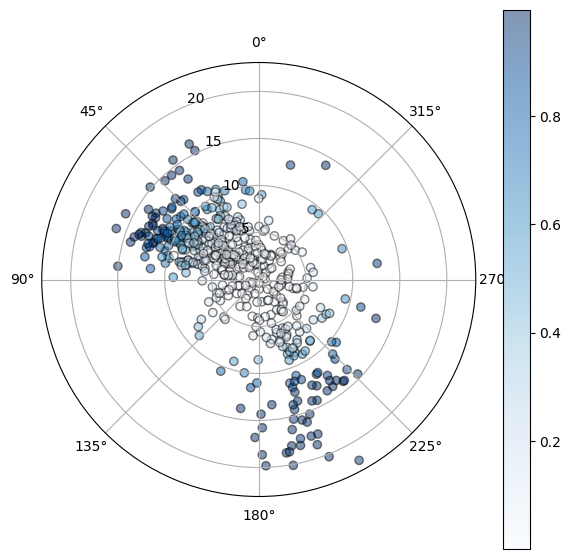

In [14]:
from math import radians
import matplotlib as mpl

sampleDF = dataDF.sample(n=500, random_state=1234)

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location("N")

points = plt.scatter(x=[radians(x) for x in sampleDF["Wind Direction (°)"]],
                     y=sampleDF["Wind Speed (m/s)"],
                     c=sampleDF["Norm ActivePower"],
                     alpha=0.5,
                     cmap=mpl.colormaps["Blues"],
                     edgecolors="black")

fig.colorbar(points);

This is more or less in line with our understanding so far. Stronger winds lead to higher power output, and there are two clear directions that the wind blows from.

We can now discard the ```Norm ActivePower``` column.

In [15]:
dataDF.drop("Norm ActivePower", axis=1, inplace=True)

Next, let's see if there are any times when the turbine is not generating power despite the value of ```Theoretical_Power_Curve (KWh)``` being positve.


In [16]:
len(dataDF[(dataDF["LV ActivePower (kW)"] == 0) & (dataDF["Theoretical_Power_Curve (KWh)"] !=0)])

3497

It looks like there is a substantial number of such observations, which could be a sign of a problem. Let's see how the non-power generating events are distributed over the individual months of the year.

In [17]:
nogenDF = dataDF[(dataDF["LV ActivePower (kW)"] == 0) & (dataDF["Theoretical_Power_Curve (KWh)"] !=0)]
nogenDF = nogenDF.groupby("Month")["Month"].count().to_frame()
nogenDF = nogenDF.rename(columns={"Month": "Count"}).reset_index()
nogenDF.head()

,Month,Count
0,1,803
1,2,458
2,3,184
3,4,284
4,5,277


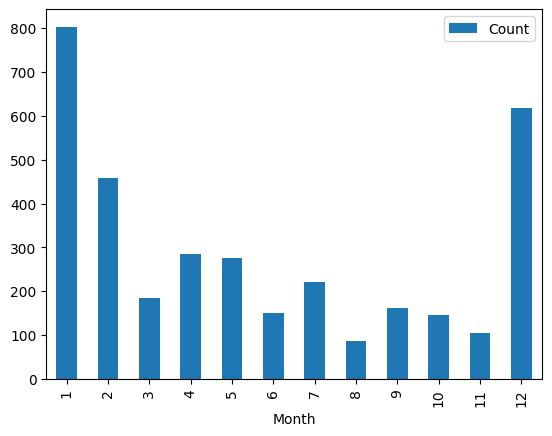

In [18]:
nogenDF.plot.bar(x="Month", y="Count");

It appears that the majority of these events are taking place during the cold months - December and January. This is likely caused by freezing of the turbine or by ice build up on the turbine blades. Let's discard the entries from the winter months as anomalies.

In [19]:
dataDF = dataDF.drop(dataDF[(dataDF["Month"]==1) | (dataDF["Month"]==12)].index)

Now let's look for other outliers in the data.

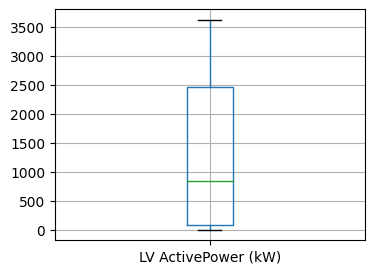

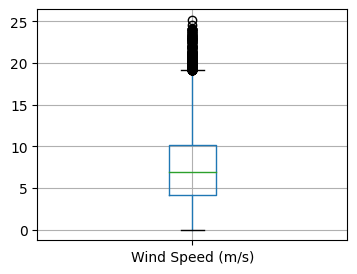

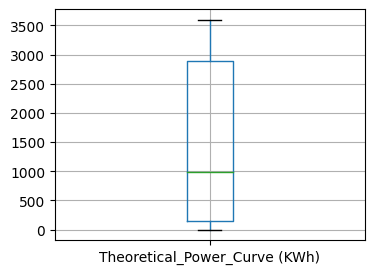

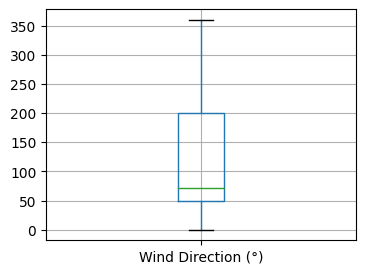

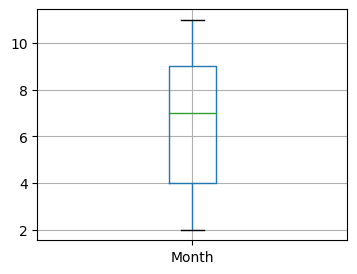

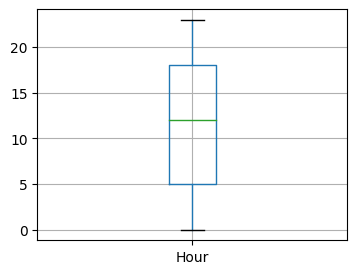

In [20]:
for column in dataDF:
    plt.figure(figsize=(4,3))
    dataDF.boxplot([column])

It all looks fairly normal except for the ```Wind Speed (m/s)```, where we observe a good amount of extreme values in the top quartile.

Let's remove the extremes by discarding the observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3.

In [21]:
Q1 = dataDF["Wind Speed (m/s)"].quantile(0.25)
Q3 = dataDF["Wind Speed (m/s)"].quantile(0.75)
IQR = Q3 - Q1

dataDF = dataDF[~((dataDF["Wind Speed (m/s)"] < (Q1 - 1.5 * IQR)) 
                  | (dataDF["Wind Speed (m/s)"] > (Q3 + 1.5 * IQR)))]

It apperas that we now have a relatively good understanding of the data. The data is also in a shape suitable for training a predictive model.

## Model training & evaluation

Let's take one more look at our final dataset.

In [22]:
dataDF.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Hour
144,3377.649902,12.70539,3591.300461,196.042206,2,0
145,3374.423096,12.18336,3547.627655,197.743896,2,0
146,3401.081055,12.20514,3550.307222,196.808807,2,0
147,3469.412109,12.60188,3585.959181,193.815704,2,0
148,3511.809082,12.84455,3595.996394,194.346603,2,0


We will split it into a training and test set using a ration of 80:20. We'll keep the test sit aside as we'll need it later for evaluating the generalisation capability of the model.

In [23]:
from sklearn.model_selection import train_test_split

trainDF, testDF = train_test_split(dataDF, test_size=0.2, random_state=1234)

In [24]:
X_train = trainDF.drop(columns=["LV ActivePower (kW)"]).values
y_train = trainDF["LV ActivePower (kW)"].values

In [25]:
X_test = testDF.drop(columns=["LV ActivePower (kW)"]).values
y_test = testDF["LV ActivePower (kW)"].values

Next, we'll train an [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)

This is an ensemble model, which uses a number of randomized decision trees on various sub-samples of the dataset.

In [26]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=1234)

Let's evaluate the model on the holdout set.

In [27]:
print("Accuracy on train: {:.0%}".format(model.score(X_train,y_train)))
print("Accuracy on test : {:.0%}".format(model.score(X_test,y_test)))

Accuracy on train: 100%
Accuracy on test : 97%


Finally, we can generate predictions on the entire dataset and visually inspect the performance of the theoretical and predicted outputs superimposed on the actual values.

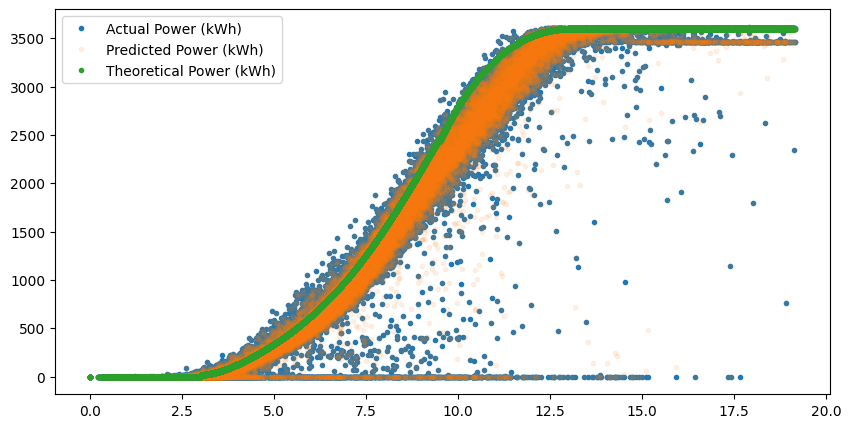

In [28]:
X = dataDF.drop(columns=["LV ActivePower (kW)"]).values
y = dataDF["LV ActivePower (kW)"].values
y_pred = model.predict(X)

plt.figure(figsize=(10,5))
plt.plot(dataDF["Wind Speed (m/s)"], y, 'o', label="Actual Power (kWh)", markersize=3)
plt.plot(dataDF["Wind Speed (m/s)"], y_pred, 'o', label='Predicted Power (kWh)', markersize=3, alpha=0.1)
plt.plot(dataDF["Wind Speed (m/s)"], dataDF["Theoretical_Power_Curve (KWh)"], 'o', label='Theoretical Power (kWh)', markersize=3)
plt.legend(fontsize=10)
plt.show()

## Persisting the model

Finally, we save the model as a [Python pickle](https://docs.python.org/3/library/pickle.html) file, so that we can deploy and access it as a [Model API](https://docs.dominodatalab.com/en/latest/user_guide/8dbc91/deploy-models-at-rest/) in Domino.

In [29]:
import pickle
 
with open("model.bin", 'wb') as f_out:
    pickle.dump(model, f_out)
    f_out.close()